# Exercise: Alternet User Clarification and Brief Generation

In the lesson, you were presented with an invitation to try an altenate implementation.

One implementation of this is shown below. You can compare it to your implementation. 
You can add suggestions or comments to the course or the student forum.

-----------

In this notebook, we used **structured output** with Pydantic schemas (`ClarifyWithUser`) to control workflow decisions. 

However, there's an alternative approach using **tool binding** that's worth exploring.

#### Structured Output v Tool Calling

```python
structured_output_model = model.with_structured_output(ClarifyWithUser)
response = structured_output_model.invoke([...])

if response.need_clarification:
    return Command(goto=END, ...)
else:
    return Command(goto="write_research_brief", ...)
```

**Benefits:**
- Predictable, deterministic workflow control
- Clear schema validation  
- Less prone to hallucination
- Faster and more cost-effective

Instead of structured output, we could bind tools to the LLM to tell it to go ahead and write the research brief.

```python
def proceed_with_research(verification_message: str) -> str:
    """Call this tool when you have enough information to proceed with research."""
    return f"Proceeding with research: {verification_message}"

# Bind tools to model
llm_with_tools = model.bind_tools([proceed_with_research])

def clarify_with_user(state: AgentState):
    response = llm_with_tools.invoke([...])
    
    # Check if tools were called
    if response.tool_calls:
        tool_call = response.tool_calls[0]
        if tool_call["name"] == "proceed_with_research":
            return Command(goto="write_research_brief", update={"messages": [AIMessage(content=tool_call["args"]["verification_message"])]})
    
    ...
```

Try implementing the tool calling approach.

You will need to modify the prompts to instruct the LLM to use the tool. 

This also gives to more feedback to add additional tools in this scoping phase, if needed! 



In [1]:
#%%writefile ../src/deep_research_from_scratch/state.py

from typing import Optional
from pydantic import BaseModel, Field
from langgraph.graph import MessagesState

class AgentState(MessagesState):
    research_brief: Optional[str]

class ClarifyWithUser(BaseModel):
    need_clarification: bool = Field(
        description="Whether the user needs to be asked a clarifying question.",
    )
    question: str = Field(
        description="A question to ask the user to clarify the report scope",
    )
    verification: str = Field(
        description="Verify message that we will start research after the user has provided the necessary information.",
    )

class ResearchQuestion(BaseModel):
    research_brief: str = Field(
        description="A research question that will be used to guide the research.",
    )

In [63]:
import sys
sys.path.append("../src/")

In [64]:
from rich.markdown import Markdown
from deep_research_from_scratch.prompts import clarify_with_user_instructions
Markdown(clarify_with_user_instructions)

These are the messages that have been exchanged so far from the user asking for the report:  {messages}            

Today's date is {date}.                                                                                            

Assess whether you need to ask a clarifying question, or if the user has already provided enough information for   
you to start research. IMPORTANT: If you can see in the messages history that you have already asked a clarifying  
question, you almost always do not need to ask another one. Only ask another question if ABSOLUTELY NECESSARY.     

If there are acronyms, abbreviations, or unknown terms, ask the user to clarify. If you need to ask a question,    
follow these guidelines:                                                                                           

 • Be concise while gathering all necessary information                                                            
 • Make sure to gather all the information needed to carry out the research task in a concise, well-structured     
   manner.                                                                                                         
 • Use bullet points or numbered lists if appropriate for clarity. Make sure that this uses markdown formatting and
   will be rendered correctly if the string output is passed to a markdown renderer.                               
 • Don't ask for unnecessary information, or information that the user has already provided. If you can see that   
   the user has already provided the information, do not ask for it again.                                         



Respond in valid JSON format with these exact keys: "need_clarification": boolean, "question": "", "verification": 
""                                                                                                                 


If you need to ask a clarifying question, return: "need_clarification": true, "question": "", "verification": ""   


If you do not need to ask a clarifying question, return: "need_clarification": false, "question": "",              
"verification": ""                                                                                                 

For the verification message when no clarification is needed:                                                      

 • Acknowledge that you have sufficient information to proceed                                                     
 • Briefly summarize the key aspects of what you understand from their request                                     
 • Confirm that you will now begin the research process                                                            
 • Keep the message concise and professional

In [85]:
clarify_with_user_instructions_tools_version="""
These are the messages that have been exchanged so far from the user asking for the report:
<Messages>
{messages}
</Messages>

Today's date is {date}.

Assess whether you need to ask a clarifying question, or if the user has already provided enough information for you to start research.
IMPORTANT: If you can see in the messages history that you have already asked a clarifying question, 
you almost always do not need to ask another one. Only ask another question if ABSOLUTELY NECESSARY.

If there are acronyms, abbreviations, or unknown terms, ask the user to clarify.
If you need to ask a question, follow these guidelines:
- Be concise while gathering all necessary information
- Make sure to gather all the information needed to carry out the research task in a concise, well-structured manner.
- Use bullet points or numbered lists if appropriate for clarity. Make sure that this uses markdown formatting and will be rendered correctly if the string output is passed to a markdown renderer.
- Don't ask for unnecessary information, or information that the user has already provided. If you can see that the user has already provided the information, do not ask for it again.

Respond with a verification messages and proceed with research if you do not need more clarifying questions.
If you need more information, respond with a question for the user.
"""

### Workflow

At this stage of the workflow, we use structured output to make clear, deterministic decisions about whether we have sufficient context to proceed with research. This approach has several advantages:
- **Predictability**: The decision logic is explicit and consistent
- **Reliability**: Less prone to hallucination or unexpected behavior
- **Debuggability**: Easy to understand why a particular decision was made
- **Performance**: Faster and more cost-effective than complex reasoning loops

We use LangGraph's [Command system](https://langchain-ai.github.io/langgraph/how-tos/graph-api/#combine-control-flow-and-state-updates-with-command) to control workflow flow while simultaneously updating state. The `Command` object takes two key parameters:
- `goto`: Specifies the next node to execute (or `END` to terminate)
- `update`: Dictionary of state updates to apply before transitioning

This pattern allows our functions to both process data and direct the workflow based on their results, creating a more flexible and maintainable system than traditional static graph structures.

In [86]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-scope-researcher"

In [97]:
#%%writefile ../src/deep_research_from_scratch/scope_research.py 
"""
User Clarification and Research Brief Generation

This module implements the scoping phase of the research workflow, where we:
1. Assess if the user's request needs clarification
2. Generate a detailed research brief from the conversation

The workflow uses structured output to make deterministic decisions about
whether sufficient context exists to proceed with research.
"""

from datetime import datetime
from typing import Literal

from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, AIMessage, get_buffer_string
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from langgraph.graph import MessagesState
from langchain_core.tools import tool

# from deep_research_from_scratch.prompts import clarify_with_user_instructions, transform_messages_into_research_topic_prompt
# from deep_research_from_scratch.state import AgentState, ClarifyWithUser, ResearchQuestion

# ===== UTILITY FUNCTIONS =====

def get_today_str() -> str:
    """Get current date in a human-readable format."""
    return datetime.now().strftime("%a %b %-d, %Y")

# ===== CONFIGURATION =====

# Initialize model
model = init_chat_model(model="openai:gpt-4.1")


# ===== Define a new tools =====

def proceed_with_research( verification_message: str  ) -> str:
    """Call this tool when you have enough information to proceed with research."""
    return f"Proceeding with research: {verification_message}"

# ===== WORKFLOW NODES =====

# Bind tools to model
llm_with_tools = model.bind_tools([proceed_with_research])

def clarify_with_user(state: AgentState) -> Command[Literal["write_research_brief", "__end__"]]:
    response = llm_with_tools.invoke([HumanMessage(content=clarify_with_user_instructions_tools_version.format(
             messages=get_buffer_string(messages=state["messages"]), 
             date=get_today_str()
         ))
    ])
    #print(response)
    # Check if tools were called
    if response.tool_calls:
        tool_call = response.tool_calls[0]
        if tool_call["name"] == "proceed_with_research":
            return Command(goto="write_research_brief", 
                           update={"messages": [AIMessage(content=tool_call["args"]["verification_message"])]})
    else:
        return Command(
            goto=END, 
            update={"messages": [AIMessage(content=response.content)]}
        )


def write_research_brief(state: AgentState):
    """
    Research brief generation node.
    
    Transforms the conversation history into a comprehensive research brief
    that will guide the subsequent research phase.
    
    Uses structured output to ensure the brief follows the required format
    and contains all necessary details for effective research.
    """
    # Set up structured output model
    structured_output_model = model.with_structured_output(ResearchQuestion)
    
    # Generate research brief from conversation history
    response = structured_output_model.invoke([
        HumanMessage(content=transform_messages_into_research_topic_prompt.format(
            messages=get_buffer_string(state.get("messages", [])),
            date=get_today_str()
        ))
    ])
    
    # Update state with generated research brief
    return {
        "research_brief": response.research_brief,
    }

# ===== GRAPH CONSTRUCTION =====

# Build the scoping workflow
deep_researcher_builder = StateGraph(AgentState, input_schema=MessagesState)

# Add workflow nodes
deep_researcher_builder.add_node("clarify_with_user", clarify_with_user)
deep_researcher_builder.add_node("write_research_brief", write_research_brief)

# Add workflow edges
deep_researcher_builder.add_edge(START, "clarify_with_user")
deep_researcher_builder.add_edge("write_research_brief", END)

# Compile the workflow
scope_research = deep_researcher_builder.compile()

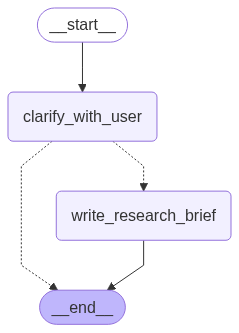

In [98]:
#%load_ext autoreload
#%autoreload 2

# Compile with in-memory checkpointer to test in notebook
from IPython.display import Image, display
from langgraph.checkpoint.memory import InMemorySaver
#from deep_research_from_scratch.scope_research import deep_researcher_builder

checkpointer = InMemorySaver()
deep_researcher_ntbk_testing = deep_researcher_builder.compile(checkpointer=checkpointer)
display(Image(deep_researcher_ntbk_testing.get_graph(xray=True).draw_mermaid_png()))

In [99]:
# Run the workflow
from utils import format_messages
from langchain_core.messages import HumanMessage
thread = {"configurable": {"thread_id": "1"}}
result = deep_researcher_ntbk_testing.invoke({"messages": [HumanMessage(content="I want to research the best coffee shops in SF near me.")]}, config=thread)
format_messages(result['messages'])

Task clarify_with_user with path ('__pregel_pull', 'clarify_with_user') wrote to unknown channel branch:to:__end__, ignoring it.


╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to research the best coffee shops in SF near me.                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ To research the best coffee shops in San Francisco near you, I would need to know your current location or      │
│ neighborhood in SF. Could you please provide your address, intersection, or the name of your neighborhood? This │
│ will help me find coffee shops that are actually near you. Thank you!                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [100]:
result = deep_researcher_ntbk_testing.invoke({"messages": [HumanMessage(content="I live near 2nd street and Harrison in SF")]}, config=thread)
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to research the best coffee shops in SF near me.                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ To research the best coffee shops in San Francisco near you, I would need to know your current location or      │
│ neighborhood in SF. Could you please provide your address, intersection, or the name of your neighborhood? This │
│ will help me find coffee shops that are actually near you. Thank you!                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I live near 2nd street and Harrison in SF                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The user provided their location as near 2nd Street and Harrison in San Francisco. This is sufficient to begin  │
│ researching the best coffee shops near that area.                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [101]:
Markdown(result["research_brief"])

What are the best coffee shops within a reasonable walking distance of the intersection of 2nd Street and Harrison 
Street in San Francisco as of July 2025? Please include coffee shops that are highly rated for quality of coffee,  
atmosphere, and service, based on recent user reviews and ratings (from platforms like Google Maps, Yelp, or       
official coffee shop websites). I have not specified preferences for coffee style, food offerings, opening hours,  
or ambiance, so please include a diverse range. Whenever possible, link directly to the official website or        
reputable sources for each coffee shop. "Best" may be defined by overall user ratings, uniqueness, or local        
popularity, so please state the key criteria for selection if they are not uniform.

## What did you think?

Which solution did you feel was best? 
Feel free to voice your opinion on the student forum!